In [0]:
! pip install fastai==0.7.0

     |████████████████████████████████| 122kB 5.1MB/s 
     |████████████████████████████████| 496.4MB 28kB/s 
     |████████████████████████████████| 1.5MB 44.2MB/s 
  Stored in directory: /root/.cache/pip/wheels/9f/78/26/fb8c0acb91a100dc8914bf236c4eaa4b207cb876893c40b745
Successfully built bcolz
ERROR: torchvision 0.3.0 has requirement torch>=1.1.0, but you'll have torch 0.3.1 which is incompatible.
  Found existing installation: torch 1.1.0
    Uninstalling torch-1.1.0:
      Successfully uninstalled torch-1.1.0
  Found existing installation: fastai 1.0.54
    Uninstalling fastai-1.0.54:
      Successfully uninstalled fastai-1.0.54


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import *
from fastai.structured import add_datepart

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
os.chdir('/content/drive/My Drive/PStock/Data/test')

In [0]:
path = "/content/drive/My Drive/PStock/Data/test/"
file = "Pepsico.csv"
file2 = "Alibaba.csv"
file3 = "VinGroup.csv"

In [0]:
def split_data(file_path, test_size=0.2):
  #constructing additional features using fastai module
  print(file_path)
    data = pd.read_csv(file_path)
    X = data.loc[:, ['date', 'open']]
    y = data['close']
    print(len(data.values))
    df_diff_y = y - y.shift()
  
    add_datepart(X, 'date')
    X.drop('Elapsed', axis=1, inplace=True) 

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, shuffle=False)
    return X_train, X_test, y_train, y_test, df_diff_y

In [0]:
def split_dataVN(file_path, test_size=0.2):
  #constructing additional features using fastai module and manually created features based on knowledge of Vietnamese tradition
  print(file_path)
    data = pd.read_csv(file_path)
    X = data.loc[:, ['date', 'open']]
    y = data['close']
    print(len(data.values))
    df_diff_y = y - y.shift()
  
    add_datepart(X, 'date')
    X.drop('Elapsed', axis=1, inplace=True) 
  
  
  
    X['Viathantai'] = 0
    X['Tetamlich'] = 0
    for i in range(len(X)):
        if X['Month'][i] == 2 and X['Day'][i] == 25:
            X['Viathantai'][i] = 1
        else:
            X['Viathantai'][i] = 0
      
    for i in range(len(X)):
        if (X['Month'][i] == 1 and X['Day'][i] in range (26,32)) or (X['Month'][i] == 2 and X['Day'][i] in range (1,10)):
              X['Tetamlich'] = 1
        else:
              X['Tetamlich'] = 0

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, shuffle=False)
    return X_train, X_test, y_train, y_test, df_diff_y

In [0]:
def draw_graph(X_train, X_test, y_train, y_test):
  #finding optimal value of K corresponding to lowest RMSE and MAPE observed
    RMSE = []
    MAPE = []
    for i in range(1,60):
        y_pred = KNeighborsRegressor(n_neighbors=i).fit(X_train,y_train).predict(X_test)
      
        RMSE.append(math.sqrt(mean_squared_error(y_pred,y_test)))
        MAPE.append(mape_eval(y_test,y_pred))
      
    plt.figure(figsize=(12, 8), dpi=80)
    plt.plot(range(1, 60), RMSE, 'x-')
    plt.grid()
    plt.xlabel('k')
    plt.ylabel('RMSE')
  
    plt.figure(figsize=(12, 8), dpi=80)
    plt.plot(range(1, 60), MAPE, 'x-')
    plt.grid()
    plt.xlabel('k')
    plt.ylabel('MAPE')
  
    plt.show()
  

In [0]:
def get_accuracy( y_pred, y_test):
 
  #constructing predicted movement array
    movement_pred = pd.DataFrame(y_pred) - pd.DataFrame(y_pred).shift()
    movement_pred.dropna(inplace = True)
  
    for i in range(len(movement_pred)):
        if movement_pred.iat[i,0] > 0:
            movement_pred.iat[i,0] = 1
        else:
            movement_pred.iat[i,0] = 0
        
  #constructing ground truth movement array
    movement_gt = pd.DataFrame(y_test) - pd.DataFrame(y_test).shift()
    movement_gt.dropna(inplace = True)
  
    for i in range(len(movement_gt)):
        if movement_gt.iat[i,0] > 0:
            movement_gt.iat[i,0] = 1
        else:
            movement_gt.iat[i,0] = 0
        
  #compare and calculate accuracy as number of correct prediction over number of observation
    movement = (movement_pred==movement_gt)
    accuracy = np.unique(movement, return_counts=True)[1][1] / len(movement)
  
  return accuracy

In [0]:
#calculating RMSE and MAPE
def get_metrics(y_pred,y_test):
    y_test = np.array(y_test)
    y_pred = np.array(y_pred)
    z = pd.DataFrame(np.abs((y_test - y_pred)/y_test)).replace(np.inf, np.nan)
    MAPE = z.mean() * 100
    
    RMSE = math.sqrt(mean_squared_error(y_pred,y_test))
    print('RMSE %2f' %(RMSE))
    print('MAPE %2f' %(MAPE))
    return RMSE,MAPE

In [0]:
def create_model(file_path):
    if file_path == file3:
        X_train, X_test, y_train, y_test, df_diff_y = split_dataVN(file_path)
    else:
        X_train, X_test, y_train, y_test, df_diff_y = split_data(file_path)
    scaler = MinMaxScaler(feature_range=(0, 1))
    X_train = scaler.fit_transform(X_train)
    y_train = scaler.fit_transform(y_train.values.reshape(-1, 1))


    X_test = scaler.fit_transform(X_test)
    y_test = scaler.fit_transform(y_test.values.reshape(-1, 1))
  
    draw_graph(X_train, X_test, y_train, y_test)
  
    return X_train, X_test, y_train, y_test, scaler

# *PEPSICO K-NEAREST NEIGHBOR*!

Pepsico.csv
2518


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dis

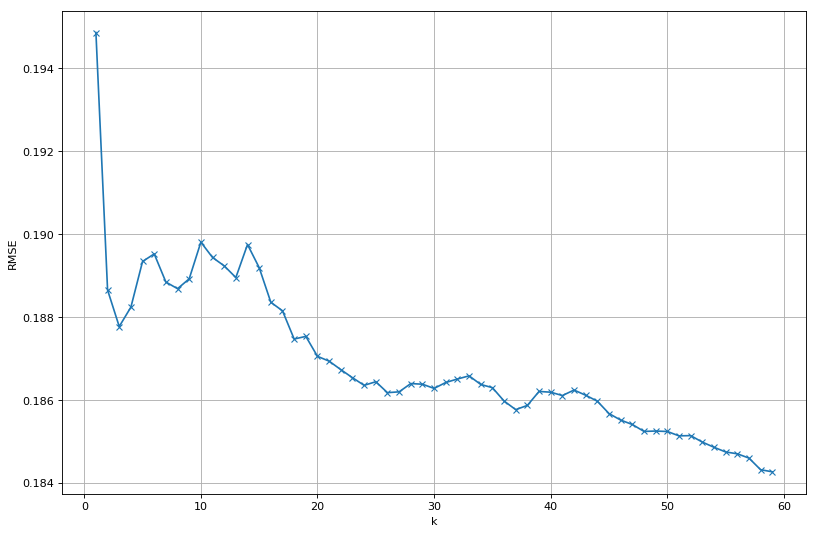

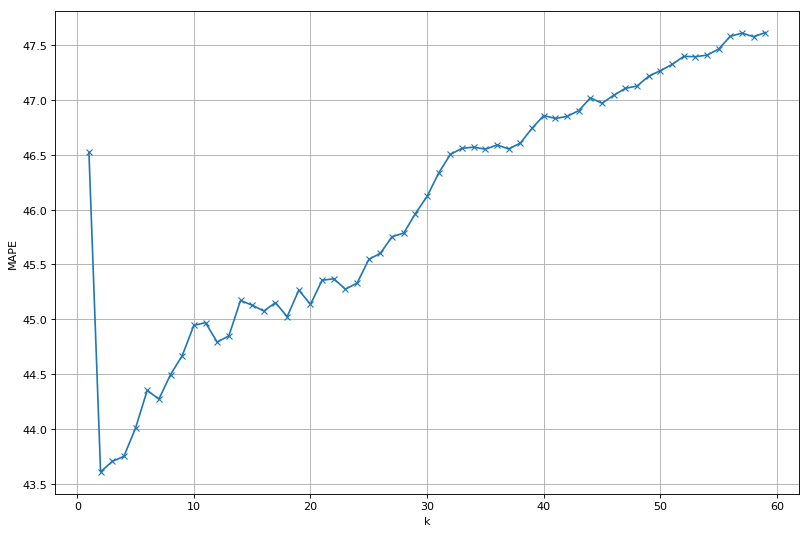

In [0]:
X_train, X_test, y_train, y_test, scaler = create_model(file)

In [0]:
knn = KNeighborsRegressor(n_neighbors = 59)
knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)
accuracy = get_accuracy(y_pred,y_test)
rmse,mape = get_metrics(y_pred,y_test)

RMSE 0.184259
MAPE 47.611961


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


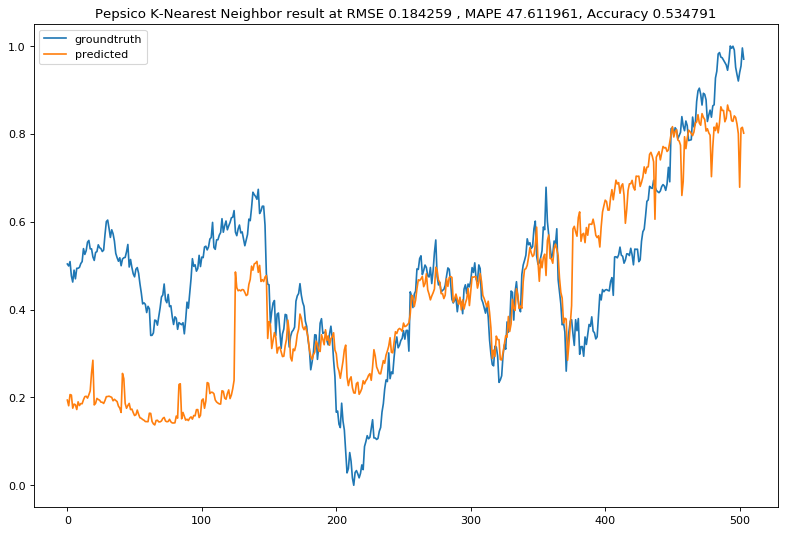

In [0]:
plt.figure(figsize=(12, 8), dpi=80)
plt.title('Pepsico K-Nearest Neighbor result at RMSE %2f , MAPE %2f, Accuracy %2f' %(rmse,mape,accuracy))
plt.plot(y_test,label = 'groundtruth')
plt.plot(y_pred,label='predicted')
plt.legend()

# ALIBABA K-NEAREST NEIGHBOR

Alibaba.csv
1206


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dis

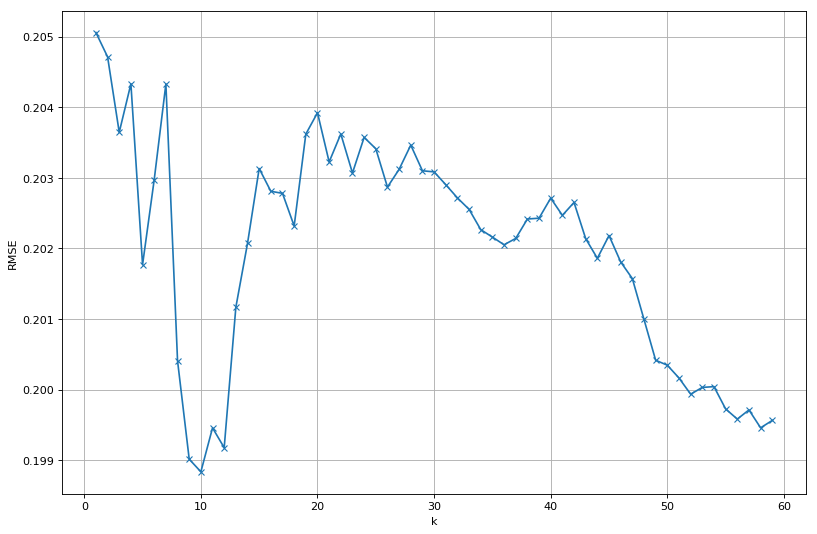

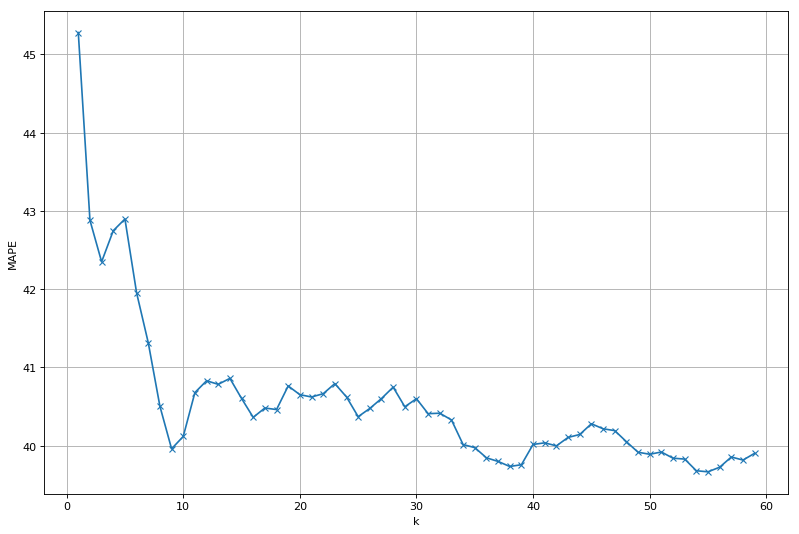

In [0]:
X_train2, X_test2, y_train2, y_test2, scaler2 = create_model(file2)

In [0]:
knn2 = KNeighborsRegressor(n_neighbors = 10)
knn2.fit(X_train2,y_train2)
y_pred2 = knn.predict(X_test2)
accuracy2 = get_accuracy(y_pred2,y_test2)
rmse2,mape2 = get_metrics(y_pred2,y_test2)

RMSE 0.223460
MAPE 48.055764


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


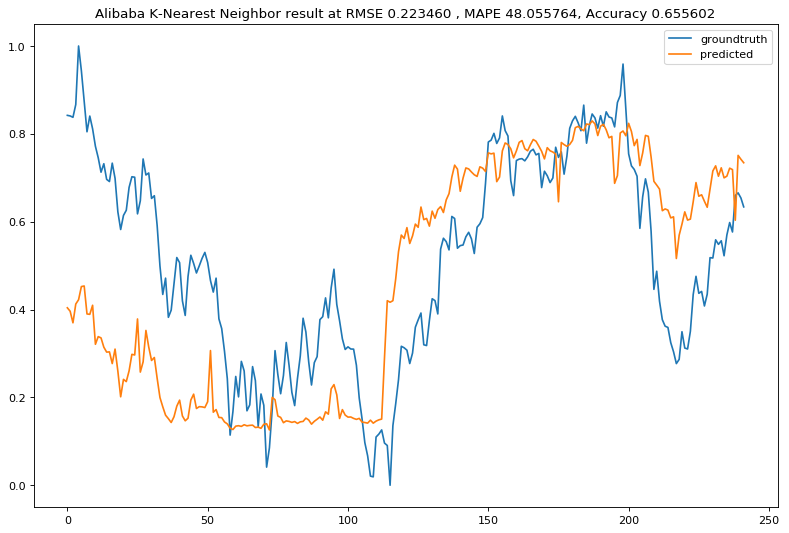

In [0]:
plt.figure(figsize=(12, 8), dpi=80)
plt.title('Alibaba K-Nearest Neighbor result at RMSE %2f , MAPE %2f, Accuracy %2f' %(rmse2,mape2,accuracy2))
plt.plot(y_test2,label = 'groundtruth')
plt.plot(y_pred2,label='predicted')
plt.legend()

# VINGROUP K-NEAREST NEIGHBOR

VinGroup.csv
2493


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by 

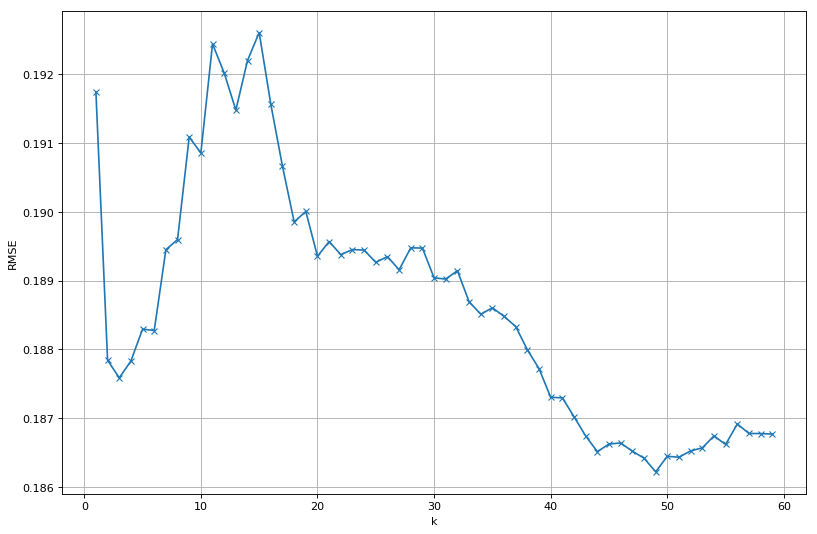

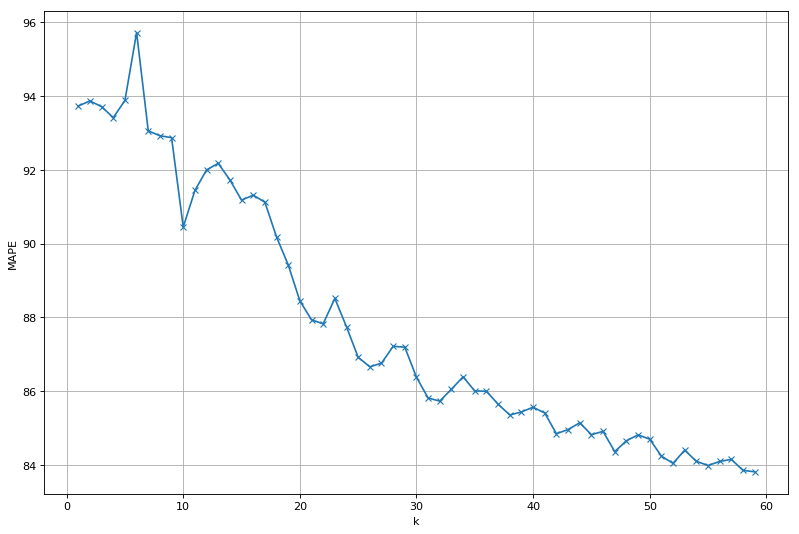

In [0]:
X_train3, X_test3, y_train3, y_test3, scaler3 = create_model(file3)

In [0]:
knn3 = KNeighborsRegressor(n_neighbors = 49)
knn3.fit(X_train3,y_train3)
y_pred3 = knn3.predict(X_test3)
accuracy3 = get_accuracy(y_pred3,y_test3)
rmse3,mape3 = get_metrics(y_pred3,y_test3)

RMSE 0.186225
MAPE 84.816872


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


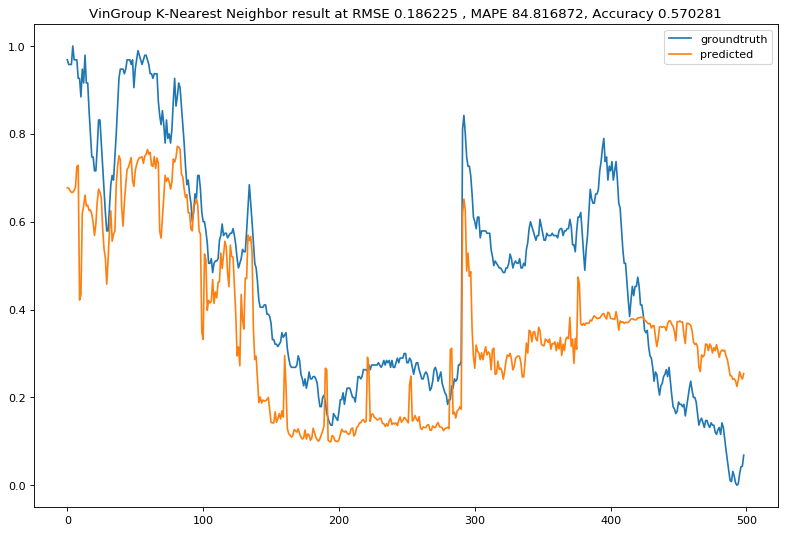

In [0]:
plt.figure(figsize=(12, 8), dpi=80)
plt.title('VinGroup K-Nearest Neighbor result at RMSE %2f , MAPE %2f, Accuracy %2f' %(rmse3,mape3,accuracy3))
plt.plot(y_test3,label = 'groundtruth')
plt.plot(y_pred3,label='predicted')
plt.legend()